### Initialize the client

As seen in the "1kg.ipynb" example, we take the following steps to create the client object that will be used to obtain the information we desire and query the server. Plotting tools are also imported here.

In [1]:
import ga4gh.client as client
c = client.HttpClient("http://1kgenomes.ga4gh.org")

import collections
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

### Acquiring annotation set

We query the server for the dataset, which is the 1k-genomes dataset. The dataset has a unique ID that can be used to acquire each variant set within the dataset. 

To access the different kinds of annotations, we access the annotation set using the unique variant set ID.

In [7]:
dataset = c.searchDatasets().next()

for variantSet in c.searchVariantSets(dataset.id):
    #print(variantSet)
    if variantSet.name == "functional-annotation":
        annotation = variantSet

annotationSet = c.searchVariantAnnotationSets(variantSetId=annotation.id).next()

### Summarizing and storing annotation statistics

This function lists and counts the different kinds of <a href="https://en.wikipedia.org/wiki/Bioinformatics#Genome_annotation" target="_blank">annotations</a> in the DNA sequence.

These statistics are passed onto the graphing function, plotStatistics, in order to be graphed into different visual representations of the data.

In [28]:
def summarizeAnnotations(annotationSetId=None, start=None, end=None, chrom=None):
    termsAndCounts = collections.OrderedDict()
    grandTotal = {}
    typesOfAnnotations = 0
    totalAnnotations = 0
    
    # The series of loops add the type of annotation (term.term) and the count of how many of this specific
    # type of annotation are in the sequnce into the termsAndCounts dictionary.
    for annotation in c.searchVariantAnnotations(annotationSetId, start=start, end=end, referenceName=chrom):
        for eff in annotation.transcript_effects:
            for term in eff.effects:
                if term.term in termsAndCounts:
                    termsAndCounts[term.term]['count'] += 1
                    totalAnnotations += 1
                else:
                    termsAndCounts[term.term] = {}
                    termsAndCounts[term.term]['count'] = 1
                    totalAnnotations +=1
    
    for items in termsAndCounts:
        typesOfAnnotations += 1
    
    # The final set of statistics in the dictionary are the count of how many unique annotations there are in the
    # sequence and the grand total of annotations in the sequence.
    grandTotal['statistics'] = {}
    grandTotal['statistics']['types_of_annotations'] = typesOfAnnotations
    grandTotal['statistics']['total_annotations'   ] = totalAnnotations
    
    #print(termsAndCounts.items)
    orderedTermsAndCounts = collections.OrderedDict(sorted(termsAndCounts.items(), None, lambda x: x[1]['count']))
    #print("termsAndCounts = ",termsAndCounts)
    #print("grandTotal = ",grandTotal)
    #print("orderedTermsAndCounts = ",orderedTermsAndCounts)
    plotStatistics(annotationData=orderedTermsAndCounts)

### Plotting statistics

This function creates x/y-axis information and percentages based on the annotation data (the annotation terms and counts). It stores the data in specific way so that matplotlib can interpret it.

In [33]:
def plotStatistics(annotationData):
    xValues = [None]*(len(annotationData)+1)
    yValues = [None]*(len(annotationData)+1)
    
    i=0
    j=0
    for items in annotationData:
        for counts in annotationData[items]:
            xValues[i] = items
            yValues[i] = annotationData[items][counts]
            i+=1
        
    xAxisTicks = xValues[:(len(annotationData))]
    yAxisValues = yValues[:(len(annotationData))]
    
    #plt.rcParams["figure.figsize"] = [len(xAxisTicks)+5,len(xAxisTicks)+5]
    
    plotHistogram(xAxisTicks, yAxisValues)

### Histogram

This function is called by the plotStatistics function and will create a histogram of the data

In [69]:
def plotHistogram(xAxisTicks,yAxisValues):
    
    t = np.arange(0.01, 20.0, 0.01)
    
    fig, ax = plt.subplots()
    
    xRange = np.arange(len(xAxisTicks))
    
    ax.set_xticklabels(xAxisTicks, rotation=45, ha='left')
    ax.set_xticks(xRange)
    
    h = plt.bar(xrange(len(xAxisTicks)), yAxisValues, label=xAxisTicks)
    xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
    plt.xticks(xticks_pos, xAxisTicks,  ha='right', rotation=45)
    
    #plt.semilogy(t, np.exp(-t/5.0))
    #plt.gca().set_yscale('log')
    plt.bar(xRange,yAxisValues)

    plt.show()

### Graphing the data

Finally, we call the summarizeAnnotations function which will graph the data based on the specified annotation ID, start location, end location, and chromosome.

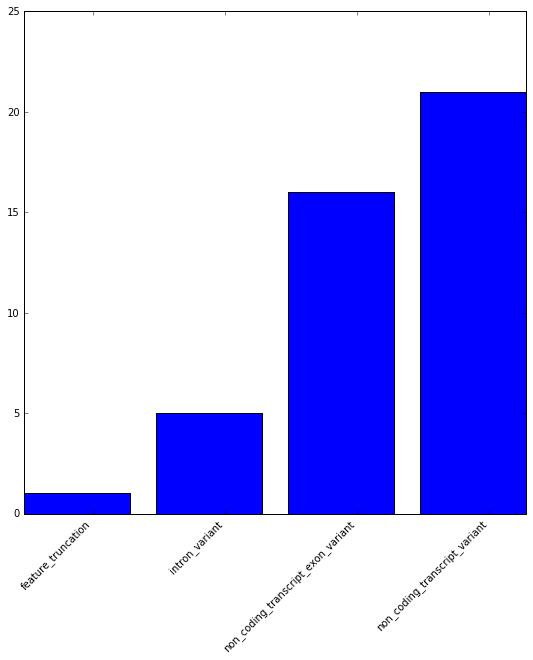

In [70]:
summarizeAnnotations(annotationSetId=annotationSet.id,start=12000,end=14000,chrom="1")

In [71]:
def f(startPosition,endPosition):
    summarizeAnnotations(annotationSetId=annotationSet.id,start=startPosition,end=endPosition,chrom="1")

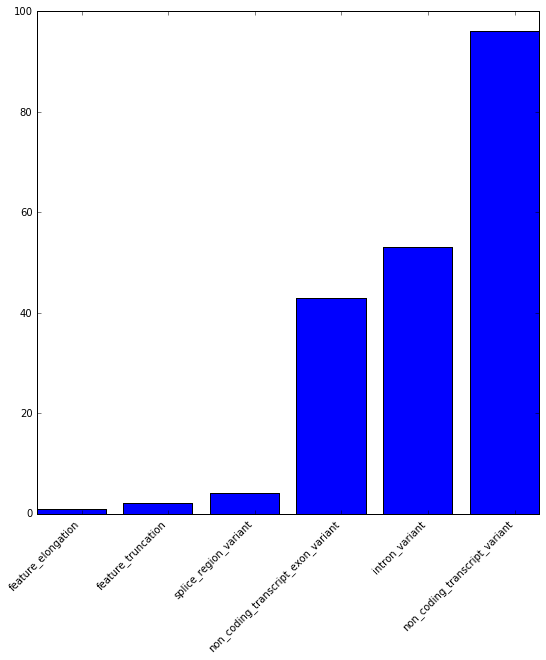

In [72]:
interact(f, startPosition=fixed(12000), endPosition=widgets.IntSlider(min=14000,max=140000,step=1000,value=14000))

In [22]:
def returnIt(x):
    return x

In [23]:
interact(returnIt, x='Hello');

u'Hello'